In [1]:
import osmnx as ox
import geopandas as gpd
import numpy as npm
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from rtree.index import Index as RTreeIndex
from shapely.geometry import Point
from shapely.geometry import LineString
from shapely.geometry import MultiLineString
from collections import deque
import datetime
import xml.etree.ElementTree as et 
from tqdm import tqdm
import networkx as nx
import json

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
CRS_NYC = 'EPSG:2263'
CRS_LATLON = 'EPSG:4326'
DATA_DIR = '../data'
EXPORTS_DIR = f'{DATA_DIR}/citibike/exports'

In [3]:
def peek(df):
    display(df.iloc[:3])
    print(len(df))
    
def hash_station_id(station_id):
    try:
        float_id = float(station_id)
        int_id = int(float(station_id))
        if int_id == float_id:
            return str(int_id)
        else:
            return str(float_id)
    except:
        return str(station_id)

In [4]:
def graph_to_node_gdf(G):
    """Converts the given graph to a GeoDataFrame of its nodes."""
    nodes, data = zip(*G.nodes(data=True))
    geom = [Point(node[0], node[1]) for node in nodes]
    nodes_gdf = gpd.GeoDataFrame(data,
                                 index=list(nodes),
                                 crs=CRS_LATLON,
                                 geometry=geom)
    return nodes_gdf

In [5]:
def graph_to_edge_gdf(G):
    """Converts the given graph to a GeoDataFrame of its edges."""
    u, v, data = zip(*G.edges(data=True))
    edges = list(zip(u, v))
    geom = [
        LineString((Point(edge[0][0],
                          edge[0][1]), Point(edge[1][0], edge[1][1])))
        for edge in edges
    ]
    edge_index = [(edge[0] + edge[1]) for edge in edges]
    edges_gdf = gpd.GeoDataFrame(data,
                                 index=edge_index,
                                 crs=CRS_LATLON,
                                 geometry=list(geom))
    edges_gdf['length'] = edges_gdf.geometry.length
    return edges_gdf

## Create Bike Lane Network

In [6]:
LANES_DATE_STRING = '202101'
DATE_STRING = '202110'

In [7]:
lanes_mg = nx.read_shp(f'{DATA_DIR}/geo/lanes/' +
                       f'{LANES_DATE_STRING}_lanes_citibike_area.shp')
lanes_mg.graph['crs'] = CRS_LATLON

# Select only the largest weakly connected component.
lanes_wcc = max(nx.weakly_connected_components(lanes_mg), key=len)
lanes_mg = lanes_mg.subgraph(lanes_wcc)

# Remove directionality due to incorrect infeasible paths!j
lanes_g = nx.Graph(lanes_mg)

In [8]:
node_gdf = graph_to_node_gdf(lanes_g)
edge_gdf = graph_to_edge_gdf(lanes_g)

In [9]:
# Add edge length as attribute.
attrs = {}
for edge in edge_gdf.iterrows():
    k, v = (edge[0][0], edge[0][1]), (edge[0][2], edge[0][3])
    attrs = lanes_g.get_edge_data(k, v)
    attrs['length'] = edge[1]['length']

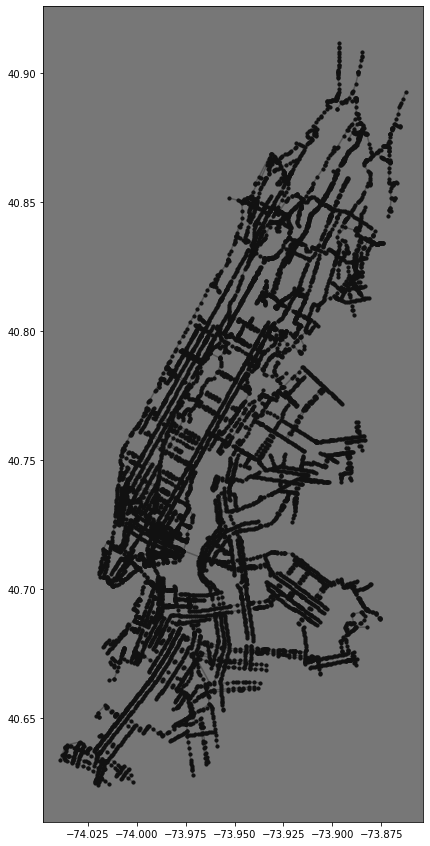

In [10]:
fig, ax = plt.subplots(figsize=(15, 15))
edge_gdf.plot(ax=ax, color='#555', zorder=1)
node_gdf.plot(ax=ax, markersize=10, color='#111', zorder=2)
ax.set_facecolor('#777')

## Identify Citi Bike Stations Near Network

In [11]:
stations_df = pd.read_csv(f'{EXPORTS_DIR}/station_coords.csv')
stations_df['date'] = stations_df['date'].astype(str)

nyc_gdf = gpd.read_file(f'{DATA_DIR}/geo/bridge_area.shp')
nyc_gdf = nyc_gdf[['geometry']].drop_duplicates()

def clean_stations_df(stations_gdf):
    """Filters stations to only those within NYC Citi Bike Service Area."""
    gdf = gpd.sjoin(stations_gdf, nyc_gdf, how='inner', op='within')
    gdf = gdf.drop(columns=['index_right'])
    return gdf


def get_stations_for_date(date_string):
    """Returns a dataframe with the most recent station positions prior to the
    given YYYYMM date string."""
    
    # Select all stations prior to the given date string.
    stations_before_df = stations_df[stations_df['date'] < date_string]
    # Select the most recent of those stations.
    stations_recent_df = stations_before_df.groupby(
        by=['id']).last().reset_index()

    # Only select stations with at least one trip leaving or entering..
    adf = pd.read_csv(
        f'{DATA_DIR}/citibike/exports/adjacency_matrices/csv/' +
        f'{date_string}_trip_count.csv'
    )
    adf = adf.set_index(adf.columns[0])
    adf.index.name = None
    adf = adf.iloc[:, 1:]
    adf.index = [hash_station_id(i) for i in adf.index]
    adf.columns = [hash_station_id(i) for i in adf.columns]
    stations_set = set(list(adf.index) + list(adf.columns))
    stations_nonzero_df = stations_recent_df[stations_recent_df['id'].isin(
        stations_set)]

    return stations_nonzero_df


def get_stations_gdf_for_date(date_string):
    df = get_stations_for_date(date_string)
    gdf = gpd.GeoDataFrame(df,
                           geometry=gpd.points_from_xy(df['lon'], df['lat']),
                           crs=CRS_LATLON)
    gdf = clean_stations_df(gdf)
    return gdf

<AxesSubplot:>

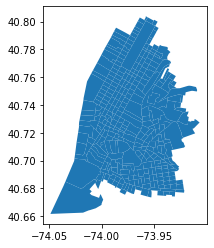

In [12]:
nyc_gdf.plot()

In [13]:
stations_gdf = get_stations_gdf_for_date(DATE_STRING)

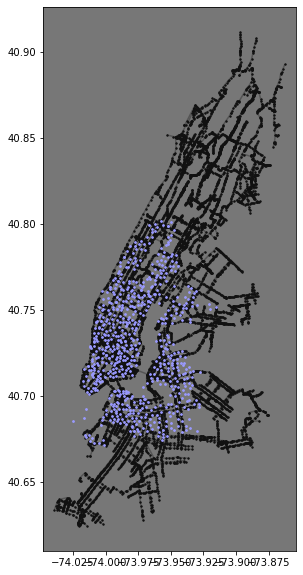

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
edge_gdf.plot(ax=ax, color='#555', zorder=1)
node_gdf.plot(ax=ax, markersize=2, color='#111', zorder=2)
stations_gdf.plot(ax=ax, markersize=3, color='#99f', zorder=3)
ax.set_facecolor('#777')

In [15]:
def closest_node(station, nodes):
    """Returns the closest node of the given nodes to the given station."""
    min_node = None
    min_dist = 100
    for node in nodes:
        dist = station.distance(node)
        if dist < min_dist:
            min_dist = dist
            min_node = node
    return ((min_node.x, min_node.y), min_dist)

In [16]:
# Requires a Citi Bike station to be within 0.001 degrees of a node in order to
# select it.
STATION_THRESHOLD = 0.001

nodes = list(node_gdf['geometry'])
stations = list(stations_gdf['geometry'])

# Create a dictionary of stations within STATION_THRESHOLD degrees of a node.
prox_dict = {
    (station.x, station.y): closest_node(station, nodes) for station in stations
}
prox_dict = {k: v for k, v in prox_dict.items() if v[1] < 0.001}

In [17]:
prox_station_geoms = [Point(k) for k in prox_dict.keys()]

stations_gdf = stations_gdf[stations_gdf.geometry.isin(prox_station_geoms)]
stations_gdf['node'] = stations_gdf.geometry.apply(lambda g: prox_dict[(g.x, g.y)][0])
stations_gdf = stations_gdf.set_index('id')

In [18]:
station_nodes_gdf = node_gdf.merge(stations_gdf[['node']], left_index=True, right_on='node', how='inner')

### Restrict to Active Citi Bike Stations

In [19]:
def get_am_df(date_string, station_nodes_gdf):
    am_df = pd.read_csv(f'{DATA_DIR}/citibike/exports/adjacency_matrices/csv/' + f'{date_string}_trip_count.csv')
    am_df = am_df.set_index(am_df.columns[0])
    am_df.index.name = None
    am_df = am_df.iloc[:, 1:]
    am_df.index = [hash_station_id(i) for i in am_df.index]
    am_df = am_df[am_df.index.isin(station_nodes_gdf.index)]
    am_df = am_df[(c for c in am_df.columns if c in am_df.index)]
    am_df = am_df.loc[list(am_df.columns), :]
    return am_df

In [20]:
def get_station_nodes_gdf(date_string):
    stations_gdf = get_stations_gdf_for_date(date_string)
    stations_gdf = stations_gdf[stations_gdf.geometry.isin(prox_station_geoms)]
    stations_gdf['node'] = stations_gdf.geometry.apply(lambda g: prox_dict[
        (g.x, g.y)][0])
    stations_gdf = stations_gdf.set_index('id')
    station_nodes_gdf = node_gdf.merge(stations_gdf[['node']],
                                       left_index=True,
                                       right_on='node',
                                       how='inner')
    return station_nodes_gdf

def reduce_station_nodes_gdf(station_nodes_gdf, am_df):
    station_nodes_gdf = station_nodes_gdf.merge(
        am_df, how='inner', left_index=True,
        right_index=True)[station_nodes_gdf.columns]
    return station_nodes_gdf

In [21]:
am_df = get_am_df(DATE_STRING, station_nodes_gdf)

In [22]:
station_nodes_gdf = station_nodes_gdf.merge(am_df, how='inner', left_index=True, right_index=True)[station_nodes_gdf.columns]

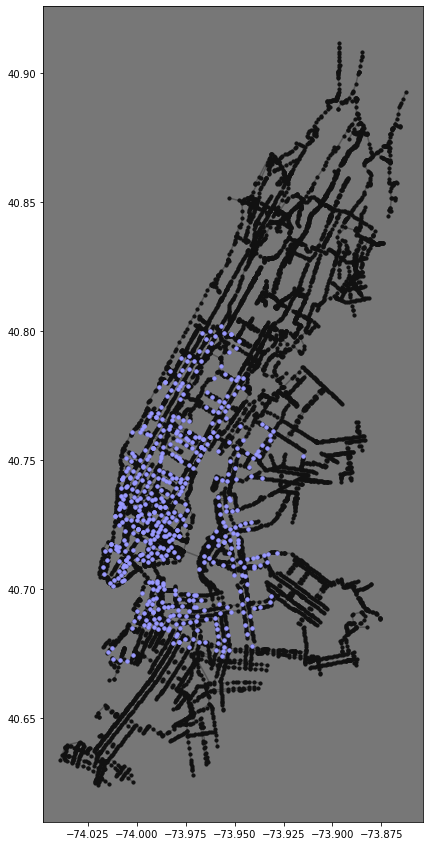

In [23]:
fig, ax = plt.subplots(figsize=(15, 15))
edge_gdf.plot(ax=ax, color='#555', zorder=1)
node_gdf.plot(ax=ax, markersize=10, color='#111', zorder=2)
station_nodes_gdf.plot(ax=ax, markersize=12, color='#99f', zorder=3)
ax.set_facecolor('#777')

## Find Shortest Paths for O-D Pairs for Single Origin

In [24]:
def path_to_edge_list(path):
    return [(path[i], path[i + 1]) for i in range(len(path) - 1)]

In [25]:
def path_to_edge_gdf(G, edges):
    geom = [LineString((Point(edge[0][0], edge[0][1]), Point(edge[1][0], edge[1][1]))) for edge in edges]
    edge_index = [(edge[0] + edge[1]) for edge in edges]
    edges_gdf = gpd.GeoDataFrame({}, index=edge_index, crs=CRS_LATLON, geometry=list(geom))
    return edges_gdf

In [26]:
def get_edge_key(gdf, edge):
    key1 = (
        edge[0][0],
        edge[0][1],
        edge[1][0],
        edge[1][1],
    )
    key2 = (
        edge[1][0],
        edge[1][1],
        edge[0][0],
        edge[0][1],
    )
    return key1 if key1 in gdf.index else key2

In [27]:
# Only consider O-D pairs with a minimum number of trips.
TRIP_THRESHOLD = 3

def get_destination_ids(orig_id, trip_threshold=TRIP_THRESHOLD):
    dest_ids = am_df[am_df[orig_id] >= trip_threshold][orig_id]
    return list(dest_ids.index)

In [28]:
def get_station_node(station_id):
    return station_nodes_gdf.loc[station_id, 'node']

In [29]:
# Choose an example origin near the east side of the Wiliamsburg Bridge.
orig_id = '5117.05'
dest_ids = get_destination_ids(orig_id, trip_threshold=5)

In [30]:
orig_node = get_station_node(orig_id)
dest_ids = get_destination_ids(orig_id)
dest_nodes = [get_station_node(dest_id) for dest_id in dest_ids]
path_gdfs = []

for dest_node in dest_nodes:
    path = nx.shortest_path(lanes_g, orig_node, dest_node, weight='length')
    edge_list = path_to_edge_list(path)
    path_gdfs.append(path_to_edge_gdf(lanes_g, edge_list))

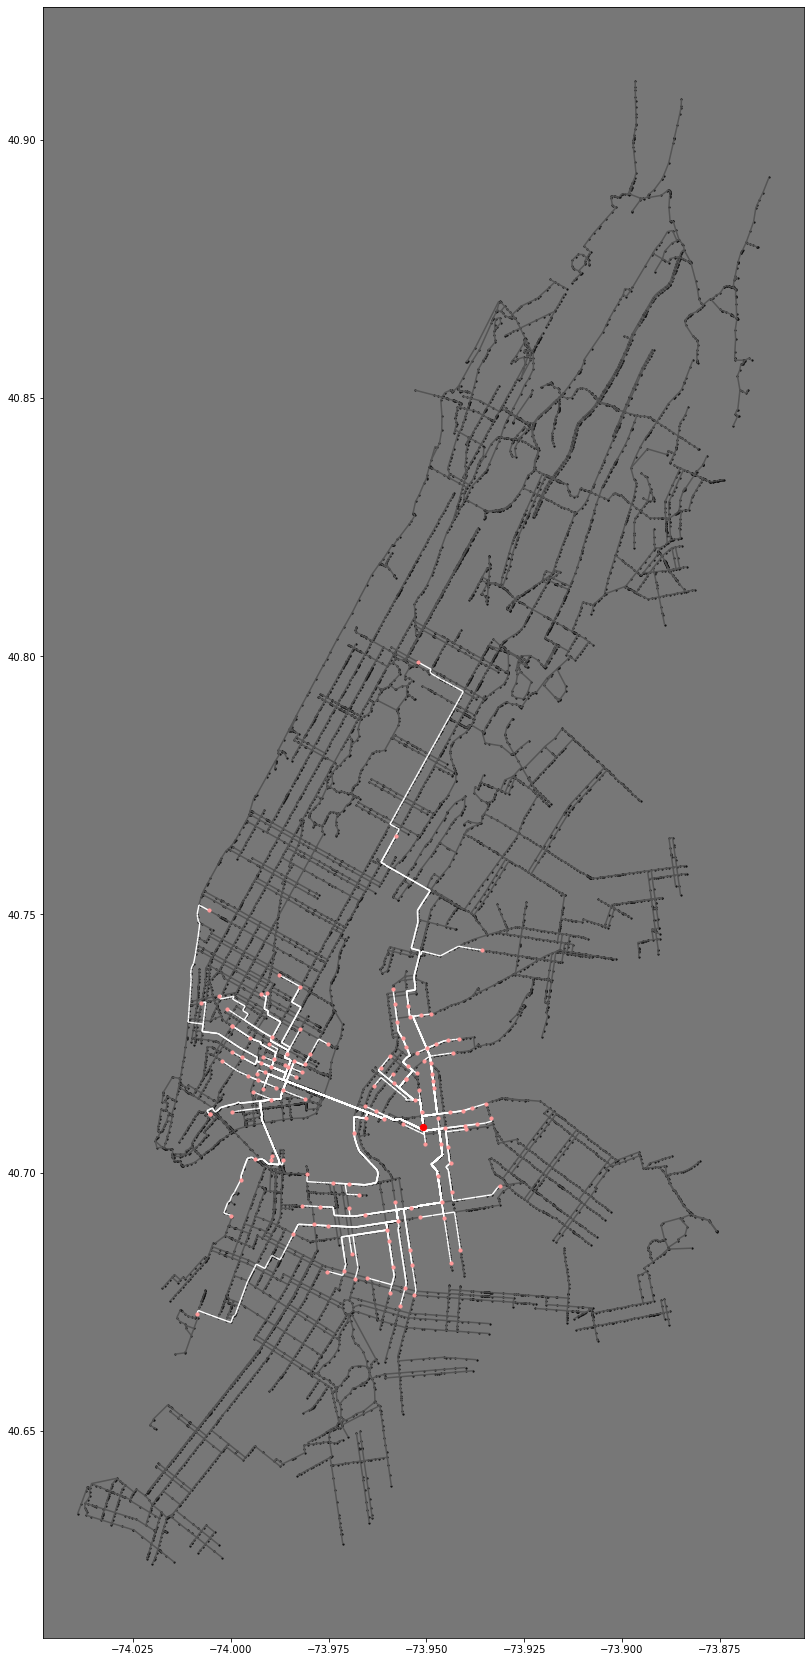

In [31]:
fig, ax = plt.subplots(figsize=(30, 30))
node_gdf.plot(ax=ax, markersize=1.5, color='#111', zorder=1)
edge_gdf.plot(ax=ax, color='#555', zorder=2)
for path_gdf in path_gdfs:
    path_gdf.plot(ax=ax, color='#fff', zorder=3)
dest_lats = [node[1] for node in dest_nodes]
dest_lons = [node[0] for node in dest_nodes]
ax.scatter(dest_lons, dest_lats, s=10, color='#f99', zorder=4)
ax.scatter([orig_node[0]], [orig_node[1]], s=40, color='#f00', zorder=5)
ax.set_facecolor('#777')

## Count Probable Trips Across Every Edge in Bike Lane Network

In [37]:
graph_path_dict = {}
node_path_dict = {}

def hash_node(node):
    return (node[0], node[1])

In [139]:
node_path_dict = {}

In [140]:
def get_edge_count_gdf(am_df, station_nodes_gdf, date_string):
    edge_trip_count_dict = {}

    for orig_id in list(station_nodes_gdf.index):
        orig_node = get_station_node(orig_id)
        dest_ids = get_destination_ids(orig_id)
        orig_hash = hash_node(orig_node)

        for dest_id in dest_ids:
            dest_node = get_station_node(dest_id)
            dest_hash = hash_node(dest_node)
            
            # Check cache
            edge_list = None
            if orig_hash in graph_path_dict:
                if dest_hash in graph_path_dict[orig_hash]:
                    edge_list = graph_path_dict[orig_hash][dest_hash]
            
            if edge_list is None:
                path = nx.shortest_path(lanes_g, orig_node, dest_node, weight='length')
                edge_list = path_to_edge_list(path)
                
                # Add to cache
                if orig_hash not in graph_path_dict:
                    graph_path_dict[orig_hash] = {}
                graph_path_dict[orig_hash][dest_hash] = edge_list
            
            for edge in edge_list:
                edge_key = get_edge_key(edge_gdf, edge)
                if edge_key not in edge_trip_count_dict:
                    edge_trip_count_dict[edge_key] = 0
                edge_trip_count_dict[edge_key] += am_df[orig_id][dest_id]
                
            if date_string not in node_path_dict:
                node_path_dict[date_string] = {}
            if orig_id not in node_path_dict[date_string]:
                node_path_dict[date_string][orig_id] = {}
            if dest_id not in node_path_dict[date_string][orig_id]:
                node_path_dict[date_string][orig_id][dest_id] = edge_list
                
    edge_count_gdf = edge_gdf[['segmentid', 'length', 'geometry']]
    edge_count_gdf['count'] = [
        (edge_trip_count_dict[i] if i in edge_trip_count_dict else 0)
        for i in edge_gdf.index
    ]
    edge_count_gdf = edge_count_gdf[edge_count_gdf['count'] > 0]
    return edge_count_gdf

In [34]:
edge_count_gdf = get_edge_count_gdf(am_df, station_nodes_gdf)

In [35]:
def plot_edge_count_gdf(edge_count_gdf):
    fig, ax = plt.subplots(figsize=(30, 30))
    edge_gdf.plot(ax=ax, color='#555', zorder=1)
    node_gdf.plot(ax=ax, markersize=1.5, color='#111', zorder=2)
    edge_count_gdf.sort_values(by=['count']).plot(ax=ax, cmap='Blues_r', column='count', zorder=3, linewidth=3)
    ax.set_facecolor('#777')

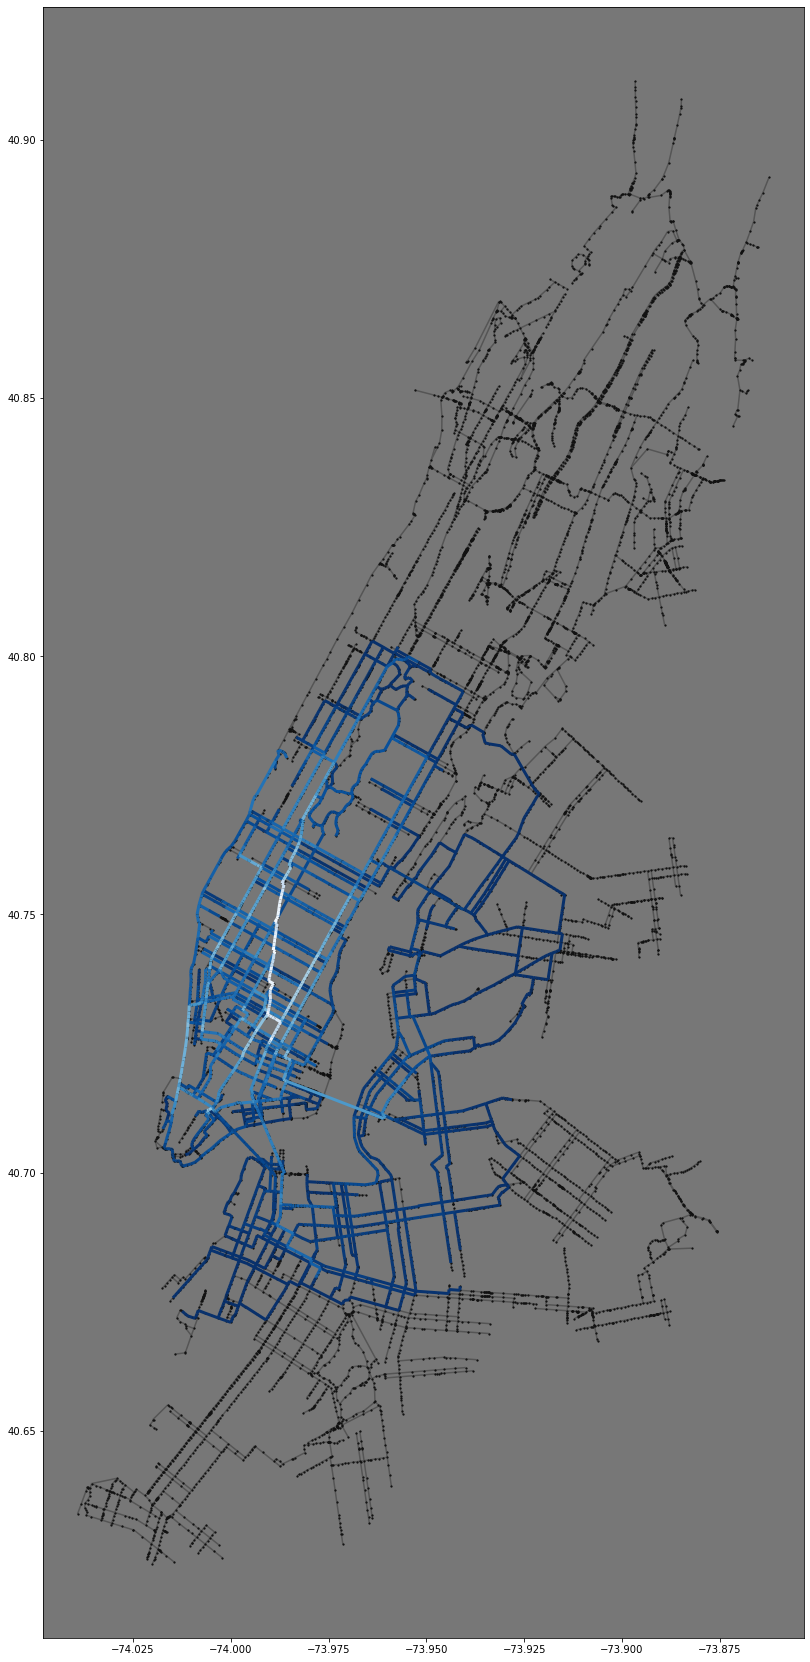

In [36]:
plot_edge_count_gdf(edge_count_gdf)

In [ ]:
edge_count_df = pd.DataFrame(edge_count_gdf[['count']])
edge_count_df.to_csv(f'{DATA_DIR}/citibike/exports/edge_counts/{DATE_STRING}_bridge_area_edge_count.csv')

## Produce Montly Edge Count Totals

In [141]:
date_strings = [
  '201501',
  '201502',
  '201503',
  '201504',
  '201505',
  '201506',
  '201507',
  '201508',
  '201509',
  '201510',
  '201511',
  '201512',
  '201601',
  '201602',
  '201603',
  '201604',
  '201605',
  '201606',
  '201607',
  '201608',
  '201609',
  '201610',
  '201611',
  '201612',
  '201701',
  '201702',
  '201703',
  '201704',
  '201705',
  '201706',
  '201707',
  '201708',
  '201709',
  '201710',
  '201711',
  '201712',
  '201801',
  '201802',
  '201803',
  '201804',
  '201805',
  '201806',
  '201807',
  '201808',
  '201809',
  '201810',
  '201811',
  '201812',
  '201901',
  '201902',
  '201903',
  '201904',
  '201905',
  '201906',
  '201907',
  '201908',
  '201909',
  '201910',
  '201911',
  '201912',
  '202001',
  '202002',
  '202003',
  '202004',
  '202005',
  '202006',
  '202007',
  '202008',
  '202009',
  '202010',
  '202011',
  '202012',
]

# XXX: Needs to use bike lane network for year.

for date_string in tqdm(date_strings):
    station_nodes_gdf = get_station_nodes_gdf(date_string)
    am_df = get_am_df(date_string, station_nodes_gdf)
    station_nodes_gdf = reduce_station_nodes_gdf(station_nodes_gdf, am_df)
    edge_count_gdf = get_edge_count_gdf(am_df, station_nodes_gdf, date_string)
    edge_count_df = pd.DataFrame(edge_count_gdf[['count']])
        #edge_count_df.to_csv(f'{DATA_DIR}/citibike/exports/edge_counts/' +
        #                     f'{date_string}_bridge_area_edge_count.csv')


100%|██████████| 72/72 [22:00<00:00, 18.34s/it]


In [126]:
import pickle
f = open('graph_path_dict.pkl', 'wb')
pickle.dump(graph_path_dict, f)
f.close()

In [127]:
wbr_edge_1 = ((-73.9857663407635, 40.717723676073476), (-73.96093753412293, 40.71047194328312))
wbr_edge_2 = ((-73.96093753412293, 40.71047194328312), (-73.9857663407635, 40.717723676073476))

In [143]:
wbr_pair_dict = {}

for date_string, path_dict in node_path_dict.items():
    for orig_id, dest_dict in path_dict.items():
        for dest_id, edge_list in dest_dict.items():
            if (wbr_edge_1 in edge_list) or (wbr_edge_2 in edge_list):
                if date_string not in wbr_pair_dict:
                    wbr_pair_dict[date_string] = set()
                wbr_pair_dict[date_string].add((orig_id, dest_id))

In [144]:
CITIBIKE_CSV_DIR = f'{DATA_DIR}/citibike/csv'
trip_dfs = []
for date_string in tqdm(date_strings):
    df = pd.read_csv(f'{CITIBIKE_CSV_DIR}/{date_string}-citibike-tripdata.csv')
    df = df.rename(
        columns={
            'Bike ID': 'bike_id',
            'Birth Year': 'birth_year',
            'End Station ID': 'end_station_id',
            'End Station Latitude': 'end_lat',
            'End Station Longitude': 'end_lon',
            'End Station Name': 'end_station_name',
            'Gender': 'gender',
            'Start Station ID': 'start_station_id',
            'Start Station Latitude': 'start_lat',
            'Start Station Longitude': 'start_lon',
            'Start Station Name': 'start_station_name',
            'Start Time': 'start_time',
            'Stop Time': 'stop_time',
            'User Type': 'user_type',
            'Trip Duration': 'trip_duration',
            'bikeid': 'bike_id',
            'birth year': 'birth_year',
            'end station id': 'end_station_id',
            'end station latitude': 'end_lat',
            'end station longitude': 'end_lon',
            'end station name': 'end_station_name',
            'end_lng': 'end_lon',
            'start station id': 'start_station_id',
            'start station latitude': 'start_lat',
            'start station longitude': 'start_lon',
            'start station name': 'start_station_name',
            'start_lng': 'start_lon',
            'starttime': 'start_time',
            'stoptime': 'stop_time',
            'tripduration': 'trip_duration',
            'usertype': 'user_type',
        })

    # Standarize station ID.
    df['start_station_id'] = df['start_station_id'].apply(
        lambda row: hash_station_id(row))
    df['end_station_id'] = df['end_station_id'].apply(
        lambda row: hash_station_id(row))
    df = df.sort_values(by=['start_station_id', 'end_station_id'])
    trip_dfs.append(df)

100%|██████████| 72/72 [13:48<00:00, 11.51s/it]


In [145]:
for i, trip_df in enumerate(trip_dfs):
    date_string = date_strings[i]
    trip_df['od_pair'] = list(zip(trip_df['start_station_id'], trip_df['end_station_id']))
    wbr_trip_df = trip_df[trip_df['od_pair'].isin(wbr_pair_dict[date_string])].reset_index(drop=True)
    wbr_trip_df.to_csv(f'{DATA_DIR}/citibike/exports/wbr_trips/{date_string}_trips.csv', index=None)